In [2]:
!pip install torch torchvision opacus

In [6]:
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from opacus import PrivacyEngine
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [4]:
BATCH_SIZE = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

N = len(train_dataset)
N

60000

In [7]:
import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from opacus import PrivacyEngine
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # optional: ignore warnings

# ---- Constants ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 5          # or 10, depending on what you used before
DELTA = 1e-5        # privacy delta

# ---- Data ----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

N = len(train_dataset)
print("Train size:", N)

# ---- Model ----
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # for MNIST: 28x28 = 784
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x shape: (batch_size, 1, 28, 28) -> flatten to (batch_size, 784)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ---- Training helper ----
def train_one_model(noise_multiplier=None, max_grad_norm=1.0):
    model = SimpleNet().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()

    epsilon = None

    if noise_multiplier is not None:
        privacy_engine = PrivacyEngine()
        model, optimizer, private_loader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            noise_multiplier=noise_multiplier,
            max_grad_norm=max_grad_norm,
        )
        train_dl = private_loader
    else:
        train_dl = train_loader

    # ---- training loop ----
    for epoch in range(EPOCHS):
        model.train()
        for x, y in train_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

    # ---- evaluation ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total

    # Compute epsilon only for DP runs
    if noise_multiplier is not None:
        epsilon = privacy_engine.get_epsilon(DELTA)

    return acc, epsilon, model
   


Train size: 60000


In [10]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        # for MNIST: 28x28 = 784
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x shape: (batch_size, 1, 28, 28) -> flatten to (batch_size, 784)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
sigma_values = [0.5, 0.8, 1.0, 1.2, 1.5]
noise_results = []

# Non-DP baseline
acc_base, eps_base, model_base = train_one_model(noise_multiplier=None)
print(f"Non-DP: accuracy = {acc_base * 100:.2f}%")
baseline_result = ("Non-DP", None, acc_base)

for sigma in sigma_values:
    print(f"\nTraining DP model with sigma = {sigma} ...")
    acc, eps, _ = train_one_model(noise_multiplier=sigma, max_grad_norm=1.0)
    noise_results.append((sigma, eps, acc))
    print(f"  -> accuracy = {acc * 100:.2f}%, epsilon = {eps:.2f}")



11/28/2025 00:27:04:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


Non-DP: accuracy = 96.73%

Training DP model with sigma = 0.5 ...


11/28/2025 00:27:45:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


  -> accuracy = 89.61%, epsilon = 7.50

Training DP model with sigma = 0.8 ...


11/28/2025 00:28:30:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


  -> accuracy = 89.57%, epsilon = 1.46

Training DP model with sigma = 1.0 ...


11/28/2025 00:29:08:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


  -> accuracy = 89.51%, epsilon = 0.80

Training DP model with sigma = 1.2 ...


11/28/2025 00:29:48:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


  -> accuracy = 89.48%, epsilon = 0.57

Training DP model with sigma = 1.5 ...
  -> accuracy = 89.45%, epsilon = 0.40


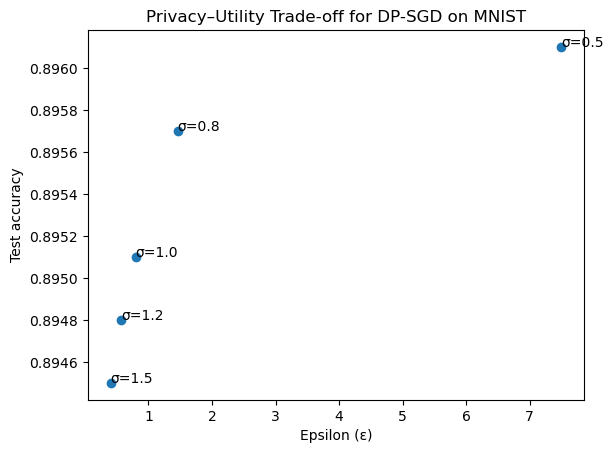

In [16]:
import matplotlib.pyplot as plt

eps_list = [eps for (_, eps, _) in noise_results]
acc_list = [acc for (_, _, acc) in noise_results]

plt.figure()
plt.scatter(eps_list, acc_list)
for (sigma, eps, acc) in noise_results:
    plt.annotate(f"σ={sigma}", (eps, acc))

plt.xlabel("Epsilon (ε)")
plt.ylabel("Test accuracy")
plt.title("Privacy–Utility Trade-off for DP-SGD on MNIST")
plt.show()

In [21]:
clipping_values = [0.5, 1.0, 2.0]
clip_results = []

sigma_fixed = 0.8  # keep this consistent with your DP experiments

for C in clipping_values:
    print(f"\nTraining DP model with sigma = {sigma_fixed}, max_grad_norm = {C} ...")
    acc, eps, _ = train_one_model(noise_multiplier=sigma_fixed, max_grad_norm=C)
    clip_results.append((C, eps, acc))
    print(f"  -> accuracy = {acc * 100:.2f}%, epsilon = {eps:.2f}")


11/28/2025 00:53:56:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.



Training DP model with sigma = 0.8, max_grad_norm = 0.5 ...


11/28/2025 00:54:32:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


  -> accuracy = 87.29%, epsilon = 1.46

Training DP model with sigma = 0.8, max_grad_norm = 1.0 ...


11/28/2025 00:55:09:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


  -> accuracy = 89.41%, epsilon = 1.46

Training DP model with sigma = 0.8, max_grad_norm = 2.0 ...
  -> accuracy = 91.04%, epsilon = 1.46


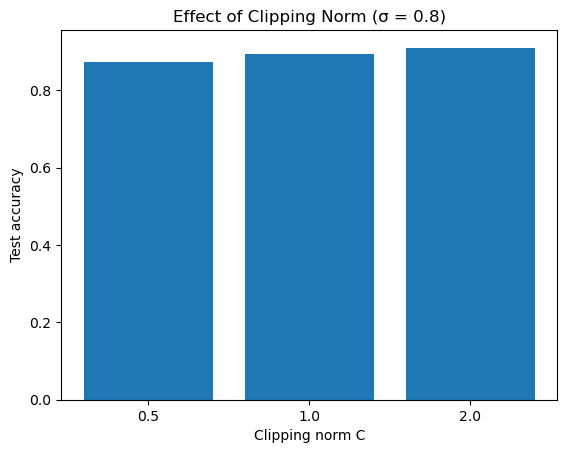

In [22]:
Cs = [C for (C, _, _) in clip_results]
accs_clip = [acc for (_, _, acc) in clip_results]

plt.figure()
plt.bar([str(C) for C in Cs], accs_clip)
plt.xlabel("Clipping norm C")
plt.ylabel("Test accuracy")
plt.title(f"Effect of Clipping Norm (σ = {sigma_fixed})")
plt.show()

In [23]:
# Non-DP model
acc_base, eps_base, model_base = train_one_model(noise_multiplier=None)
print(f"Non-DP: accuracy = {acc_base * 100:.2f}%")

# Strong-DP model
acc_dp, eps_dp, model_dp = train_one_model(noise_multiplier=1.2, max_grad_norm=1.0)
print(f"DP (sigma=1.2): accuracy = {acc_dp * 100:.2f}%, epsilon = {eps_dp:.2f}")

11/28/2025 00:56:13:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


Non-DP: accuracy = 96.68%
DP (sigma=1.2): accuracy = 89.51%, epsilon = 0.57


In [26]:
import torch.nn.functional as F

def collect_confidences(model, data_loader, max_samples=2000):
    model.eval()
    confidences = []
    count = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            max_conf, _ = probs.max(dim=1)   # max probability per sample
            confidences.extend(max_conf.cpu().numpy().tolist())
            count += x.size(0)
            if count >= max_samples:
                break
    return confidences[:max_samples]

In [27]:
# For the non-DP model
conf_train_base = collect_confidences(model_base, train_loader, max_samples=2000)
conf_test_base  = collect_confidences(model_base, test_loader,  max_samples=2000)

# For the DP model
conf_train_dp = collect_confidences(model_dp, train_loader, max_samples=2000)
conf_test_dp  = collect_confidences(model_dp, test_loader,  max_samples=2000)

In [28]:
import numpy as np

def summarize(name, train_conf, test_conf):
    print(f"\n{name}")
    print(f"  mean train confidence: {np.mean(train_conf):.4f}")
    print(f"  mean test  confidence: {np.mean(test_conf):.4f}")
    print(f"  gap (train - test):    {np.mean(train_conf) - np.mean(test_conf):.4f}")

summarize("Non-DP", conf_train_base, conf_test_base)
summarize("DP (sigma=1.2)", conf_train_dp, conf_test_dp)


Non-DP
  mean train confidence: 0.9507
  mean test  confidence: 0.9400
  gap (train - test):    0.0107

DP (sigma=1.2)
  mean train confidence: 0.9255
  mean test  confidence: 0.9160
  gap (train - test):    0.0095


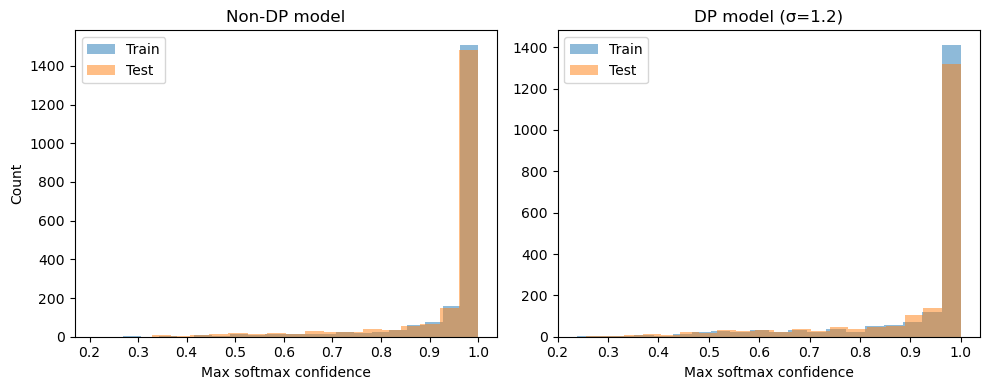

In [29]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(conf_train_base, bins=20, alpha=0.5, label="Train")
plt.hist(conf_test_base,  bins=20, alpha=0.5, label="Test")
plt.title("Non-DP model")
plt.xlabel("Max softmax confidence")
plt.ylabel("Count")
plt.legend()

plt.subplot(1,2,2)
plt.hist(conf_train_dp, bins=20, alpha=0.5, label="Train")
plt.hist(conf_test_dp,  bins=20, alpha=0.5, label="Test")
plt.title("DP model (σ=1.2)")
plt.xlabel("Max softmax confidence")
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
EPOCHS = 5 
train_loss_history = []
train_acc_history = []

In [9]:
#DP-SGD training with per-epoch loss/accuracy

noise_multiplier = 1.2      # DP noise (matches your ε≈0.57 setting)
max_grad_norm = 1.0         # clipping norm

train_loss_history_dp = []
train_acc_history_dp = []

model_dp = SimpleNet().to(DEVICE)
optimizer_dp = torch.optim.SGD(model_dp.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

privacy_engine = PrivacyEngine()
model_dp, optimizer_dp, private_loader_dp = privacy_engine.make_private(
    module=model_dp,
    optimizer=optimizer_dp,
    data_loader=train_loader,
    noise_multiplier=noise_multiplier,
    max_grad_norm=max_grad_norm,
)

for epoch in range(EPOCHS):
    model_dp.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for x, y in private_loader_dp:   # use the private loader from Opacus
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer_dp.zero_grad()
        outputs = model_dp(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer_dp.step()

        batch_size = y.size(0)
        epoch_loss += loss.item() * batch_size
        _, preds = outputs.max(1)
        correct += (preds == y).sum().item()
        total += batch_size

    avg_loss = epoch_loss / total
    train_acc = correct / total

    train_loss_history_dp.append(avg_loss)
    train_acc_history_dp.append(train_acc)

    print(f"[DP] Epoch {epoch+1}/{EPOCHS} - "
          f"Train loss: {avg_loss:.4f}, Train acc: {train_acc*100:.2f}%")

epsilon_dp = privacy_engine.get_epsilon(DELTA)
print(f"\nFinal DP epsilon (σ={noise_multiplier}): ε ≈ {epsilon_dp:.2f}")

11/29/2025 02:01:15:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


[DP] Epoch 1/5 - Train loss: 1.1811, Train acc: 67.64%
[DP] Epoch 2/5 - Train loss: 0.5282, Train acc: 82.99%
[DP] Epoch 3/5 - Train loss: 0.4498, Train acc: 86.31%
[DP] Epoch 4/5 - Train loss: 0.4217, Train acc: 87.90%
[DP] Epoch 5/5 - Train loss: 0.4154, Train acc: 88.50%

Final DP epsilon (σ=1.2): ε ≈ 0.57


In [10]:
#Non-DP baseline with per-epoch loss/accuracy

train_loss_history_base = []
train_acc_history_base = []

model_base = SimpleNet().to(DEVICE)
optimizer_base = torch.optim.SGD(model_base.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model_base.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for x, y in train_loader:   # standard (non-private) loader
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer_base.zero_grad()
        outputs = model_base(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer_base.step()

        batch_size = y.size(0)
        epoch_loss += loss.item() * batch_size
        _, preds = outputs.max(1)
        correct += (preds == y).sum().item()
        total += batch_size

    avg_loss = epoch_loss / total
    train_acc = correct / total

    train_loss_history_base.append(avg_loss)
    train_acc_history_base.append(train_acc)

    print(f"[BASE] Epoch {epoch+1}/{EPOCHS} - "
          f"Train loss: {avg_loss:.4f}, Train acc: {train_acc*100:.2f}%")

[BASE] Epoch 1/5 - Train loss: 0.4233, Train acc: 88.28%
[BASE] Epoch 2/5 - Train loss: 0.2231, Train acc: 93.54%
[BASE] Epoch 3/5 - Train loss: 0.1704, Train acc: 95.06%
[BASE] Epoch 4/5 - Train loss: 0.1386, Train acc: 96.05%
[BASE] Epoch 5/5 - Train loss: 0.1176, Train acc: 96.67%


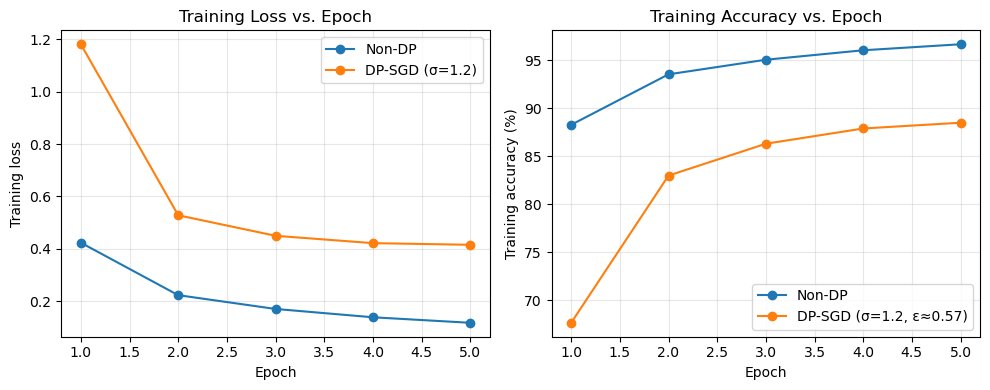

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# X-axis: epoch numbers
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(10, 4))

# --------- (a) Training loss ---------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history_base, marker='o', label='Non-DP')
plt.plot(epochs, train_loss_history_dp,   marker='o', label='DP-SGD (σ=1.2)')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training Loss vs. Epoch')
plt.legend()
plt.grid(alpha=0.3)

# --------- (b) Training accuracy ---------
plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in train_acc_history_base], marker='o', label='Non-DP')
plt.plot(epochs, [a * 100 for a in train_acc_history_dp],   marker='o', label=f'DP-SGD (σ=1.2, ε≈{epsilon_dp:.2f})')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy (%)')
plt.title('Training Accuracy vs. Epoch')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_dp_vs_base.png', dpi=300, bbox_inches='tight')
plt.show()